Motivation: Show deep CNNs can work on large-scale datasets (ImageNet).

Used ReLU activations, dropout, GPU training → big ImageNet breakthrough.

Limitation: Very large model, heavy computation.

In [1]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import accuracy_score
from torchsummary import summary

In [2]:
BATCH_SIZE = 256
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
NUM_WORKERS = 4
best_val_loss = 1e9

In [3]:
train_dataset = datasets.CIFAR10(root='../data', 
                                 train=True, 
                                 transform=transforms.ToTensor(),
                                 download=True)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          num_workers=NUM_WORKERS,
                          drop_last=True,
                          shuffle=True)

test_dataset = datasets.CIFAR10(root='../data', 
                                train=False,
                                transform=transforms.ToTensor())

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKERS,
                         drop_last=False,
                         shuffle=False)

# Checking the dataset
all_train_labels = []
all_test_labels = []

for images, labels in train_loader:  
    all_train_labels.append(labels)
all_train_labels = torch.cat(all_train_labels)
    
for images, labels in test_loader:  
    all_test_labels.append(labels)
all_test_labels = torch.cat(all_test_labels)

Files already downloaded and verified


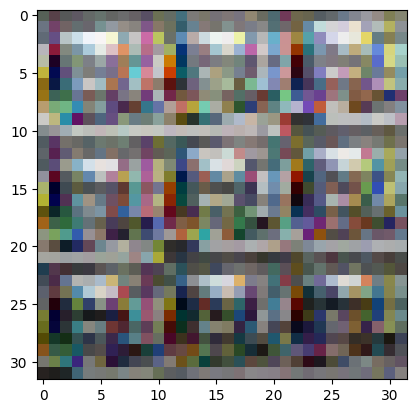

In [4]:
img = next(iter(train_loader))
plt.imshow(img[0][1].reshape(32,32,3))

In [5]:
majority_prediction = torch.argmax(torch.bincount(all_test_labels))
baseline_acc = torch.mean((all_test_labels == majority_prediction).float())
print(f'Baseline ACC: {baseline_acc*100:.2f}%')

Baseline ACC: 10.00%


In [2]:
class AlexNet(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = torch.nn.Sequential(
            
            # Conv -> Relu -> Maxpool
            torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Conv -> Relu -> Maxpool
            torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Conv -> Relu
            torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            
            # Conv -> Relu
            torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            
            # Conv -> Relu -> Maxpool (deactivated maxpool because of errors, need to debug)
            torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
#             torch.nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = torch.nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256 * 6 * 6, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        logits = self.classifier(x)
        return logits

NameError: name 'torch' is not defined

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

/opt/conda/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
device

'cpu'

In [9]:
model = AlexNet(num_classes=10)
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

57.023306 M parameters


In [10]:
summary(m,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 17, 17]           1,792
              ReLU-2           [-1, 64, 17, 17]               0
         MaxPool2d-3             [-1, 64, 8, 8]               0
            Conv2d-4            [-1, 192, 8, 8]         307,392
              ReLU-5            [-1, 192, 8, 8]               0
         MaxPool2d-6            [-1, 192, 3, 3]               0
            Conv2d-7            [-1, 384, 3, 3]         663,936
              ReLU-8            [-1, 384, 3, 3]               0
            Conv2d-9            [-1, 256, 3, 3]         884,992
             ReLU-10            [-1, 256, 3, 3]               0
           Conv2d-11            [-1, 256, 3, 3]         590,080
             ReLU-12            [-1, 256, 3, 3]               0
AdaptiveAvgPool2d-13            [-1, 256, 6, 6]               0
          Dropout-14                 [-

In [11]:
next(iter(train_loader))[0].shape

torch.Size([256, 3, 32, 32])

In [12]:
for ep in range(NUM_EPOCHS):
    all_pred_labels = []
    trl = 0
    m.train()
    for x_b, y_b in train_loader:
        x_b = x_b.to(device)
        y_b = y_b.to(device)
        logits = m(x_b)
        loss = F.cross_entropy(logits, y_b)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        trl += loss.item()
    
    m.eval()
    with torch.no_grad():
        vdl = 0
        for x_v_b, y_v_b in test_loader:
            x_v_b, y_v_b = x_v_b.to(device), y_v_b.to(device)
            logits = m(x_v_b)
            loss = F.cross_entropy(logits, y_v_b)
            vdl += loss.item()
        print(f'epoch {ep} | train_loss: {trl/len(train_loader):.4f} valid_loss: {vdl/len(test_loader):.4f}')
    
    if vdl < best_val_loss:
        best_val_loss = vdl
        for x_v_b, y_v_b in test_loader:
            x_v_b, y_v_b = x_v_b.to(device), y_v_b.to(device)
            logits = m(x_v_b)
            pred_label = F.softmax(logits,dim=-1).argmax(dim=-1)
            all_pred_labels.extend(list(pred_label.detach().cpu().flatten().numpy()))
        print("Accuracy: ",accuracy_score(all_test_labels.detach().cpu().flatten().numpy(), all_pred_labels))

epoch 0 | train_loss: 1.9979 valid_loss: 1.6400
Accuracy:  0.3551
epoch 1 | train_loss: 1.5218 valid_loss: 1.4159
Accuracy:  0.4772


KeyboardInterrupt: 

In [45]:
img = next(iter(train_loader))[0]

In [46]:
test_flow = torch.nn.Sequential(torch.nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2))

In [52]:
torch.nn.Sequential(torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2))(test_flow(img)).shape

torch.Size([256, 192, 3, 3])

In [53]:
img.shape

torch.Size([256, 3, 32, 32])